In [2]:
#import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import re
import enchant

#preprocessing
from sklearn.preprocessing import StandardScaler

#nltk libraries
import nltk

#stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

# A. Installing Libraries

In [3]:
pip install -U textblob

Requirement already up-to-date: textblob in /anaconda3/lib/python3.7/site-packages (0.15.3)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade vaderSentiment

Requirement already up-to-date: vaderSentiment in /anaconda3/lib/python3.7/site-packages (3.2.1)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pyenchant

Note: you may need to restart the kernel to use updated packages.


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# B. Creating API Functions

In [8]:
#this function takes in a timestamp
#edit the URL to add in filters
#yahoofinance
def get_data_simple(timestamp):
    url = "https://min-api.cryptocompare.com/data/v2/news/?feeds=cointelegraph&{}&categories=BTC,ETH,USDT,Mining,Market,Fiat,Regulation,Commodity,Technology,Blockchain&excludeCategories=Sponsored&lang=EN".format('lTs='+ str(timestamp)) #formats timestamp into api query
    #url = "https://min-api.cryptocompare.com/data/v2/news/?{}&excludeCategories=Sponsored&lang=EN".format('lTs='+ str(timestamp)) #formats timestamp into api query
    r = requests.get(url) #gets url
    ipdata = r.json() #saves json file
    return ipdata #returns json for df processing

In [9]:
#need to make a loop with time delays to obtain all the data and concat into one large dataframe

def api_get_df(timestamplist):
    df_list=[] #stores all dataframes
    counter = 0
    for timestamp in timestamplist[0:5]:
        df_list.append(get_df(timestamp))
        #should enter some sort of time delay because of api request limits
        counter = counter +1
        print (counter)
        if counter % 45 == 0:
            print("Taking a Break")
            time.sleep(1) #Taks a 1 second break after 45 links 
    
    #combine dataframes
    df_final = pd.concat(df_list, axis = 0)
    #df_final['date_time'] = pd.to_datetime(df_final['published_on'], unit='s') 
    return df_final #.sort_values(by = 'date_time', ascending = False) #return final combined dataframes
        

# 1. Read In Data from CSV Files and clean Files

In [10]:
#Data already taken from API, will run additional requests with different filtering parameters as needed
#designate paths
path1 = 'api_data.csv'
path2 = 'api_data_btc_eth_filter.csv'
path3 = 'api_data_btc_eth_regulations_moreetc_regs_filter_yahoofinance.csv'
path4 = 'api_data_btc_eth_regulations_moreetc_regs_filter.csv'
path5 = 'api_data_no_filters.csv'

#df=pd.concat([pd.read_csv(path1),pd.read_csv(path2),pd.read_csv(path3),pd.read_csv(path4), pd.read_csv(path5)])

df=pd.concat([pd.read_csv(path2),pd.read_csv(path3),pd.read_csv(path4)])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [11]:
df.head()

,Unnamed: 0,body,categories,date_time,downvotes,guid,id,imageurl,lang,published_on,source,source_info,tags,title,upvotes,url
0,0,Bitcoin has been trading for a premium of betw...,BTC|Market|Trading,2019-08-15 22:00:47,0,https://www.newsbtc.com/?p=393277,2813980,https://images.cryptocompare.com/news/newsbtc/...,EN,1565906447,newsbtc,"{'name': 'NewsBTC', 'lang': 'EN', 'img': 'http...",Bitcoin|Opinion|argentina|bitcoin|safe haven,Argentine Bitcoin Premium Shows Relativity of ...,0,https://www.newsbtc.com/2019/08/15/argentine-b...
1,1,Bitcoin’s market valuation has already made so...,BTC|Trading|Market,2019-08-15 22:00:21,0,https://bitcoinist.com/?p=115180,2813979,https://images.cryptocompare.com/news/bitcoini...,EN,1565906421,bitcoinist,"{'name': 'Bitcoinist', 'lang': 'EN', 'img': 'h...",Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Brandt’s Momentum Indicator Highlights Potenti...,0,https://bitcoinist.com/brandts-momentum-indica...
2,2,Paxful’s peer-to-peer Bitcoin exchange got a b...,BTC|Exchange|Trading|Fiat|Market,2019-08-15 21:55:41,0,https://decrypt.co/?p=8442,2813832,https://images.cryptocompare.com/news/decrypt/...,EN,1565906141,decrypt,"{'name': 'Decrypt', 'lang': 'EN', 'img': 'http...",Cryptocurrencies|bitcoin|cryptocurrency|Market...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,0,https://decrypt.co/8442/bitcoin-peer-to-peer-e...
3,3,"Move over, John McAfee, there&#8217;s a new cr...",BTC|Blockchain|Technology|Regulation,2019-08-15 21:21:14,0,https://cryptobriefing.com/?p=43933,2812410,https://images.cryptocompare.com/news/cryptobr...,EN,1565904074,cryptobriefing,"{'name': 'Crypto Briefing', 'lang': 'EN', 'img...",News|Bitcoin|Government|Politics|USA,Crypto Candidate Andrew Yang Talks Up Bitcoin ...,0,https://cryptobriefing.com/crypto-andrew-yang-...
4,4,TRON announced the latest release of its side ...,ETH|Blockchain|BTC|Market,2019-08-15 21:19:06,0,https://cryptoslate.com/?p=111863,2812411,https://images.cryptocompare.com/news/cryptosl...,EN,1565903946,cryptoslate,"{'name': 'CryptoSlate', 'lang': 'EN', 'img': '...",Analysis|EOS|Ethereum|Tron,Is TRON’s Sun Network a marketing gimmick? Com...,0,https://cryptoslate.com/tron-sun-network-marke...


In [12]:
df.dtypes #checking if columns have correct data type

Unnamed: 0       int64
body            object
categories      object
date_time       object
downvotes        int64
guid            object
id               int64
imageurl        object
lang            object
published_on     int64
source          object
source_info     object
tags            object
title           object
upvotes          int64
url             object
dtype: object

In [13]:
df.id = df.id.astype(str)#changing ID to str

In [14]:
df.dtypes #checking if change is successful

Unnamed: 0       int64
body            object
categories      object
date_time       object
downvotes        int64
guid            object
id              object
imageurl        object
lang            object
published_on     int64
source          object
source_info     object
tags            object
title           object
upvotes          int64
url             object
dtype: object

In [15]:
#dropping columns
df.columns

Index(['Unnamed: 0', 'body', 'categories', 'date_time', 'downvotes', 'guid',
       'id', 'imageurl', 'lang', 'published_on', 'source', 'source_info',
       'tags', 'title', 'upvotes', 'url'],
      dtype='object')

In [16]:
dropcol = ['Unnamed: 0','downvotes','guid','imageurl','lang','source_info','upvotes','url']

df_analysis = df.drop(dropcol,axis=1)

In [17]:
#remove duplicate articles

df_analysis.drop_duplicates('id',inplace = True)

In [18]:
df_analysis.shape #52257 unique articles

(45473, 8)

In [19]:
df_analysis[['body','title']].head()

,body,title
0,Bitcoin has been trading for a premium of betw...,Argentine Bitcoin Premium Shows Relativity of ...
1,Bitcoin’s market valuation has already made so...,Brandt’s Momentum Indicator Highlights Potenti...
2,Paxful’s peer-to-peer Bitcoin exchange got a b...,Bitcoin peer-to-peer exchange Paxful sees 70 p...
3,"Move over, John McAfee, there&#8217;s a new cr...",Crypto Candidate Andrew Yang Talks Up Bitcoin ...
4,TRON announced the latest release of its side ...,Is TRON’s Sun Network a marketing gimmick? Com...


In [20]:
df_analysis = df_analysis.reset_index()

In [21]:
df_analysis = df_analysis.drop(['index'],axis = 1)

In [22]:
df_analysis.head()

,body,categories,date_time,id,published_on,source,tags,title
0,Bitcoin has been trading for a premium of betw...,BTC|Market|Trading,2019-08-15 22:00:47,2813980,1565906447,newsbtc,Bitcoin|Opinion|argentina|bitcoin|safe haven,Argentine Bitcoin Premium Shows Relativity of ...
1,Bitcoin’s market valuation has already made so...,BTC|Trading|Market,2019-08-15 22:00:21,2813979,1565906421,bitcoinist,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Brandt’s Momentum Indicator Highlights Potenti...
2,Paxful’s peer-to-peer Bitcoin exchange got a b...,BTC|Exchange|Trading|Fiat|Market,2019-08-15 21:55:41,2813832,1565906141,decrypt,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Bitcoin peer-to-peer exchange Paxful sees 70 p...
3,"Move over, John McAfee, there&#8217;s a new cr...",BTC|Blockchain|Technology|Regulation,2019-08-15 21:21:14,2812410,1565904074,cryptobriefing,News|Bitcoin|Government|Politics|USA,Crypto Candidate Andrew Yang Talks Up Bitcoin ...
4,TRON announced the latest release of its side ...,ETH|Blockchain|BTC|Market,2019-08-15 21:19:06,2812411,1565903946,cryptoslate,Analysis|EOS|Ethereum|Tron,Is TRON’s Sun Network a marketing gimmick? Com...


In [23]:
#concat title and body together

df_analysis["text"] = df_analysis["title"].map(str) + ' '+ df_analysis["body"].map(str)

In [24]:
df_analysis.head(10)

,body,categories,date_time,id,published_on,source,tags,title,text
0,Bitcoin has been trading for a premium of betw...,BTC|Market|Trading,2019-08-15 22:00:47,2813980,1565906447,newsbtc,Bitcoin|Opinion|argentina|bitcoin|safe haven,Argentine Bitcoin Premium Shows Relativity of ...,Argentine Bitcoin Premium Shows Relativity of ...
1,Bitcoin’s market valuation has already made so...,BTC|Trading|Market,2019-08-15 22:00:21,2813979,1565906421,bitcoinist,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Brandt’s Momentum Indicator Highlights Potenti...,Brandt’s Momentum Indicator Highlights Potenti...
2,Paxful’s peer-to-peer Bitcoin exchange got a b...,BTC|Exchange|Trading|Fiat|Market,2019-08-15 21:55:41,2813832,1565906141,decrypt,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,Bitcoin peer-to-peer exchange Paxful sees 70 p...
3,"Move over, John McAfee, there&#8217;s a new cr...",BTC|Blockchain|Technology|Regulation,2019-08-15 21:21:14,2812410,1565904074,cryptobriefing,News|Bitcoin|Government|Politics|USA,Crypto Candidate Andrew Yang Talks Up Bitcoin ...,Crypto Candidate Andrew Yang Talks Up Bitcoin ...
4,TRON announced the latest release of its side ...,ETH|Blockchain|BTC|Market,2019-08-15 21:19:06,2812411,1565903946,cryptoslate,Analysis|EOS|Ethereum|Tron,Is TRON’s Sun Network a marketing gimmick? Com...,Is TRON’s Sun Network a marketing gimmick? Com...
5,Maryland has entered the early stages of what ...,ICO|BTC,2019-08-15 21:00:47,2811641,1565902847,livebitcoinnews,Bitcoin News|ICO|News|crypto fraud|Maryland|Texas,Maryland Initiates Operation Crypto Sweep to E...,Maryland Initiates Operation Crypto Sweep to E...
6,Bitcoin is not behaving like a safe-haven asse...,BTC|Trading|Business,2019-08-15 21:00:29,2811739,1565902829,bitcoinist,Bitcoin|News|Uncategorized|bitcoin|Dow Jones|T...,Bitcoin is Not Acting Like Safe-Haven: Ikigai ...,Bitcoin is Not Acting Like Safe-Haven: Ikigai ...
7,After facing a significant amount of downwards...,BTC|Trading,2019-08-15 21:00:14,2811642,1565902814,newsbtc,Bitcoin|Crypto|bitcoin|btc|crypto,Bitcoin May Soon Test 2019 Trend Line Below $9...,Bitcoin May Soon Test 2019 Trend Line Below $9...
8,Bitcoin cash price analysis reveals that Bitco...,Trading|BCH|Market|XRP|ETH,2019-08-15 20:57:36,2811590,1565902656,cryptopolitan,Bitcoin Cash Price|bch price|BCH price analysi...,Bitcoin Cash price analysis: BCH price hits $2...,Bitcoin Cash price analysis: BCH price hits $2...
9,"On August 13, Samsung, the South Korean multin...",BCH|ETH|Blockchain|ICO,2019-08-15 20:45:51,2811057,1565901951,bitcoin.com,News|Apple|BCH|bitcoin cash|Bitcoin Core|Block...,Samsung Adds Bitcoin Support to Its Blockchain...,Samsung Adds Bitcoin Support to Its Blockchain...


# 2. Preprocessing

In [25]:
#need to do some regrex cleaning on text column
#Regex to get rid of numbers so that only ingredients are left

#use an apply function to apply regrex to each row in nlp_ingredients
df_analysis['text'] = df_analysis['text'].apply(lambda x: re.sub(r'\b\d+\b', '', x))

#remove punctuation
df_analysis['text'] = df_analysis['text'].apply(lambda x: re.sub(r'[^\w\s]','',x))

#make all ingredients lowercase
df_analysis['text'] = df_analysis['text'].apply(lambda x: x.lower())



In [26]:
#removing stop words, need to be careful, stop words such as very, not etc are valuable for sentiment analysis

stop = stopwords.words('english')

#need to manually add and remove stopwords.

#against, above, below, down, up, no, not 
stop

#for sentiment analysis, first round, will not remove stop words to see initial 

#df_analysis = df_analysis['text'].apply(lambda x: [item for item in x if item not in stop])

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
df_analysis.head()

,body,categories,date_time,id,published_on,source,tags,title,text
0,Bitcoin has been trading for a premium of betw...,BTC|Market|Trading,2019-08-15 22:00:47,2813980,1565906447,newsbtc,Bitcoin|Opinion|argentina|bitcoin|safe haven,Argentine Bitcoin Premium Shows Relativity of ...,argentine bitcoin premium shows relativity of ...
1,Bitcoin’s market valuation has already made so...,BTC|Trading|Market,2019-08-15 22:00:21,2813979,1565906421,bitcoinist,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Brandt’s Momentum Indicator Highlights Potenti...,brandts momentum indicator highlights potentia...
2,Paxful’s peer-to-peer Bitcoin exchange got a b...,BTC|Exchange|Trading|Fiat|Market,2019-08-15 21:55:41,2813832,1565906141,decrypt,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,bitcoin peertopeer exchange paxful sees perce...
3,"Move over, John McAfee, there&#8217;s a new cr...",BTC|Blockchain|Technology|Regulation,2019-08-15 21:21:14,2812410,1565904074,cryptobriefing,News|Bitcoin|Government|Politics|USA,Crypto Candidate Andrew Yang Talks Up Bitcoin ...,crypto candidate andrew yang talks up bitcoin ...
4,TRON announced the latest release of its side ...,ETH|Blockchain|BTC|Market,2019-08-15 21:19:06,2812411,1565903946,cryptoslate,Analysis|EOS|Ethereum|Tron,Is TRON’s Sun Network a marketing gimmick? Com...,is trons sun network a marketing gimmick compa...


In [28]:
df_analysis.date_time[0]

'2019-08-15 22:00:47'

In [29]:
#Create a year_month column
df_analysis['year_month'] = df_analysis['date_time'].str[0:7]
#Create a year_month_day column
df_analysis['year_month_day'] = df_analysis['date_time'].str[0:10]







In [30]:
#convert data_time back to date_time object
df_analysis['date_time'] = pd.to_datetime(df_analysis['date_time'])

In [31]:
#Create year_week column
df_analysis['date_time_week'] = df_analysis.date_time.dt.strftime("%Y-%W")

In [32]:
df_analysis.head()

,body,categories,date_time,id,published_on,source,tags,title,text,year_month,year_month_day,date_time_week
0,Bitcoin has been trading for a premium of betw...,BTC|Market|Trading,2019-08-15 22:00:47,2813980,1565906447,newsbtc,Bitcoin|Opinion|argentina|bitcoin|safe haven,Argentine Bitcoin Premium Shows Relativity of ...,argentine bitcoin premium shows relativity of ...,2019-08,2019-08-15,2019-32
1,Bitcoin’s market valuation has already made so...,BTC|Trading|Market,2019-08-15 22:00:21,2813979,1565906421,bitcoinist,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Brandt’s Momentum Indicator Highlights Potenti...,brandts momentum indicator highlights potentia...,2019-08,2019-08-15,2019-32
2,Paxful’s peer-to-peer Bitcoin exchange got a b...,BTC|Exchange|Trading|Fiat|Market,2019-08-15 21:55:41,2813832,1565906141,decrypt,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,bitcoin peertopeer exchange paxful sees perce...,2019-08,2019-08-15,2019-32
3,"Move over, John McAfee, there&#8217;s a new cr...",BTC|Blockchain|Technology|Regulation,2019-08-15 21:21:14,2812410,1565904074,cryptobriefing,News|Bitcoin|Government|Politics|USA,Crypto Candidate Andrew Yang Talks Up Bitcoin ...,crypto candidate andrew yang talks up bitcoin ...,2019-08,2019-08-15,2019-32
4,TRON announced the latest release of its side ...,ETH|Blockchain|BTC|Market,2019-08-15 21:19:06,2812411,1565903946,cryptoslate,Analysis|EOS|Ethereum|Tron,Is TRON’s Sun Network a marketing gimmick? Com...,is trons sun network a marketing gimmick compa...,2019-08,2019-08-15,2019-32


In [33]:
df_analysis.date_time_week

0        2019-32
1        2019-32
2        2019-32
3        2019-32
4        2019-32
5        2019-32
6        2019-32
7        2019-32
8        2019-32
9        2019-32
10       2019-32
11       2019-32
12       2019-32
13       2019-32
14       2019-32
15       2019-32
16       2019-32
17       2019-32
18       2019-32
19       2019-32
20       2019-32
21       2019-32
22       2019-32
23       2019-32
24       2019-32
25       2019-32
26       2019-32
27       2019-32
28       2019-32
29       2019-32
          ...   
45443    2017-38
45444    2017-38
45445    2017-38
45446    2017-37
45447    2017-37
45448    2017-37
45449    2017-37
45450    2017-37
45451    2017-11
45452    2017-11
45453    2017-08
45454    2017-08
45455    2017-06
45456    2017-06
45457    2017-05
45458    2017-05
45459    2016-34
45460    2016-34
45461    2016-33
45462    2016-33
45463    2016-33
45464    2016-33
45465    2016-28
45466    2016-28
45467    2016-27
45468    2016-27
45469    2016-25
45470    2016-

In [34]:
df_analysis.dtypes

body                      object
categories                object
date_time         datetime64[ns]
id                        object
published_on               int64
source                    object
tags                      object
title                     object
text                      object
year_month                object
year_month_day            object
date_time_week            object
dtype: object

In [35]:
df_analysis.year_month.value_counts().sort_index()

#may need to drop months before 2017-10 because not enough data

2013-08       1
2013-09       2
2013-10       8
2013-11      12
2014-06       1
2016-06       4
2016-07       4
2016-08       6
2017-01       2
2017-02       8
2017-03       2
2017-06       4
2017-07       4
2017-08       5
2017-09     420
2017-10    1897
2017-11    1839
2017-12    1811
2018-01    1788
2018-02    1870
2018-03    2164
2018-04    2073
2018-05    2172
2018-06    2081
2018-07    2124
2018-08    2087
2018-09    2019
2018-10    2053
2018-11    1925
2018-12    2058
2019-01    2050
2019-02    1841
2019-03    2104
2019-04    1904
2019-05    1961
2019-06    2003
2019-07    2078
2019-08    1084
Name: year_month, dtype: int64

In [36]:
df_analysis.head()

,body,categories,date_time,id,published_on,source,tags,title,text,year_month,year_month_day,date_time_week
0,Bitcoin has been trading for a premium of betw...,BTC|Market|Trading,2019-08-15 22:00:47,2813980,1565906447,newsbtc,Bitcoin|Opinion|argentina|bitcoin|safe haven,Argentine Bitcoin Premium Shows Relativity of ...,argentine bitcoin premium shows relativity of ...,2019-08,2019-08-15,2019-32
1,Bitcoin’s market valuation has already made so...,BTC|Trading|Market,2019-08-15 22:00:21,2813979,1565906421,bitcoinist,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Brandt’s Momentum Indicator Highlights Potenti...,brandts momentum indicator highlights potentia...,2019-08,2019-08-15,2019-32
2,Paxful’s peer-to-peer Bitcoin exchange got a b...,BTC|Exchange|Trading|Fiat|Market,2019-08-15 21:55:41,2813832,1565906141,decrypt,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,bitcoin peertopeer exchange paxful sees perce...,2019-08,2019-08-15,2019-32
3,"Move over, John McAfee, there&#8217;s a new cr...",BTC|Blockchain|Technology|Regulation,2019-08-15 21:21:14,2812410,1565904074,cryptobriefing,News|Bitcoin|Government|Politics|USA,Crypto Candidate Andrew Yang Talks Up Bitcoin ...,crypto candidate andrew yang talks up bitcoin ...,2019-08,2019-08-15,2019-32
4,TRON announced the latest release of its side ...,ETH|Blockchain|BTC|Market,2019-08-15 21:19:06,2812411,1565903946,cryptoslate,Analysis|EOS|Ethereum|Tron,Is TRON’s Sun Network a marketing gimmick? Com...,is trons sun network a marketing gimmick compa...,2019-08,2019-08-15,2019-32


# 3. Sentiment Analysis -- Average over Time Period

In [37]:
#creating a smaller df for sentiment analysis

df_sentiment = df_analysis[['year_month', 'year_month_day','date_time', 'date_time_week','published_on','tags','body','title','text']]


In [38]:
df_sentiment.head()

,year_month,year_month_day,date_time,date_time_week,published_on,tags,body,title,text
0,2019-08,2019-08-15,2019-08-15 22:00:47,2019-32,1565906447,Bitcoin|Opinion|argentina|bitcoin|safe haven,Bitcoin has been trading for a premium of betw...,Argentine Bitcoin Premium Shows Relativity of ...,argentine bitcoin premium shows relativity of ...
1,2019-08,2019-08-15,2019-08-15 22:00:21,2019-32,1565906421,Bitcoin|Bitcoin Price|News|News teaser|bitcoin...,Bitcoin’s market valuation has already made so...,Brandt’s Momentum Indicator Highlights Potenti...,brandts momentum indicator highlights potentia...
2,2019-08,2019-08-15,2019-08-15 21:55:41,2019-32,1565906141,Cryptocurrencies|bitcoin|cryptocurrency|Market...,Paxful’s peer-to-peer Bitcoin exchange got a b...,Bitcoin peer-to-peer exchange Paxful sees 70 p...,bitcoin peertopeer exchange paxful sees perce...
3,2019-08,2019-08-15,2019-08-15 21:21:14,2019-32,1565904074,News|Bitcoin|Government|Politics|USA,"Move over, John McAfee, there&#8217;s a new cr...",Crypto Candidate Andrew Yang Talks Up Bitcoin ...,crypto candidate andrew yang talks up bitcoin ...
4,2019-08,2019-08-15,2019-08-15 21:19:06,2019-32,1565903946,Analysis|EOS|Ethereum|Tron,TRON announced the latest release of its side ...,Is TRON’s Sun Network a marketing gimmick? Com...,is trons sun network a marketing gimmick compa...


In [39]:
#utilizing vader sentiment analysis creating SentimentIntensityAnalyzer()

analyser = SentimentIntensityAnalyzer()

In [40]:
analyser.polarity_scores(df_sentiment.body[2000])

{'neg': 0.0, 'neu': 0.983, 'pos': 0.017, 'compound': 0.0772}

In [41]:
analyser.polarity_scores('bitcoin is rising')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [42]:

TextBlob(df_sentiment.body[2000]).sentiment.polarity

0.09659090909090909

In [43]:
df_sentiment.text[2000]

'singapore releases new draft on tax guidelines for crypto bitcoin ethereum litecoin dash monero ripple and zcash the inland revenue authority of singapore iras has published a draft guide that explains the goods and services tax gst treatment for transactions involving cryptocurrencies that are used as a medium of exchange referred to as digital payment tokens the draft references bitcoin ethereum litecoin dash monero ripple xrp and zcash as examples in a the post singapore releases new draft on tax guidelines for crypto bitcoin ethereum litecoin dash monero ripple and zcash appeared first on the daily hodl'

In [44]:
#Create new columns for compound scores from vader

df_sentiment['compound_score_vader'] = df_sentiment['text'].apply(lambda x: analyser.polarity_scores(x)['compound'])



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
#Create new columns for compound scores from textblob
df_sentiment['compound_score_tb'] = df_sentiment['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
#create new column for average sentiment
df_sentiment['sentiment'] = (df_sentiment['compound_score_tb'] + df_sentiment['compound_score_vader'])/2

In [50]:
df_sentiment.sort_values(by='date_time', ascending = False).head()

,year_month,year_month_day,date_time,date_time_week,published_on,tags,body,title,text,compound_score_vader,compound_score_tb,sentiment
32733,2019-08,2019-08-15,2019-08-15 22:15:00,2019-32,1565907300,Bitcoin|CNBC,"Bitcoin is a store of value, and watching the ...","Mark Yusko: Bitcoin Is a “Chaos Hedge, or Schm...",mark yusko bitcoin is a chaos hedge or schmuck...,-0.5423,-0.100000,-0.321150
32734,2019-08,2019-08-15,2019-08-15 22:06:39,2019-32,1565906799,Bitcoin Price|bitcoin price|bitcoin price anal...,Bitcoin price analysis reveals that Bitcoin (B...,"Bitcoin price analysis: BTC price hits $9500, ...",bitcoin price analysis btc price hits bears r...,-0.5789,0.021581,-0.278660
32735,2019-08,2019-08-15,2019-08-15 22:05:00,2019-32,1565906700,Blockchain|Texas|Oil|Energy|Smart Contracts|Tr...,Antelope Water Management announces that it wi...,Water Management Firm to Use Data Gumbo’s Serv...,water management firm to use data gumbos servi...,0.3612,-0.200000,0.080600
0,2019-08,2019-08-15,2019-08-15 22:00:47,2019-32,1565906447,Bitcoin|Opinion|argentina|bitcoin|safe haven,Bitcoin has been trading for a premium of betw...,Argentine Bitcoin Premium Shows Relativity of ...,argentine bitcoin premium shows relativity of ...,-0.1280,0.132000,0.002000
32736,2019-08,2019-08-15,2019-08-15 22:00:35,2019-32,1565906435,News|Altcoins|Beam|MimbleWimble|Privacy Coin,"Launching in January of this year, beam is one...",Privacy Coin Beam Conducts First Hard Fork Awa...,privacy coin beam conducts first hard fork awa...,-0.1027,0.069444,-0.016628


In [52]:
df_sentiment2 = df_sentiment[df_sentiment.published_on >= 1504224000]

df_sentiment2.to_csv('df_sentiment2.csv')

In [ ]:
df_monthly_sentiment = df_sentiment[df_sentiment.published_on >= 1504224000].groupby('year_month')['sentiment'].mean().reset_index().sort_values(by = 'year_month')

In [ ]:
df_daily_sentiment = df_sentiment[df_sentiment.published_on >= 1504224000].groupby('year_month_day')['sentiment'].mean().reset_index().sort_values(by = 'year_month_day')

In [ ]:
df_weekly_sentiment = df_sentiment[df_sentiment.published_on >= 1504224000].groupby('date_time_week')['sentiment'].mean().reset_index().sort_values(by = 'date_time_week')

In [ ]:
#scaling sentiment scores

#scalar = StandardScaler()
#scalar.fit([df_monthly_sentiment.compound_score])

#sentiment_scaled = scalar.transform([df_monthly_sentiment.compound_score])

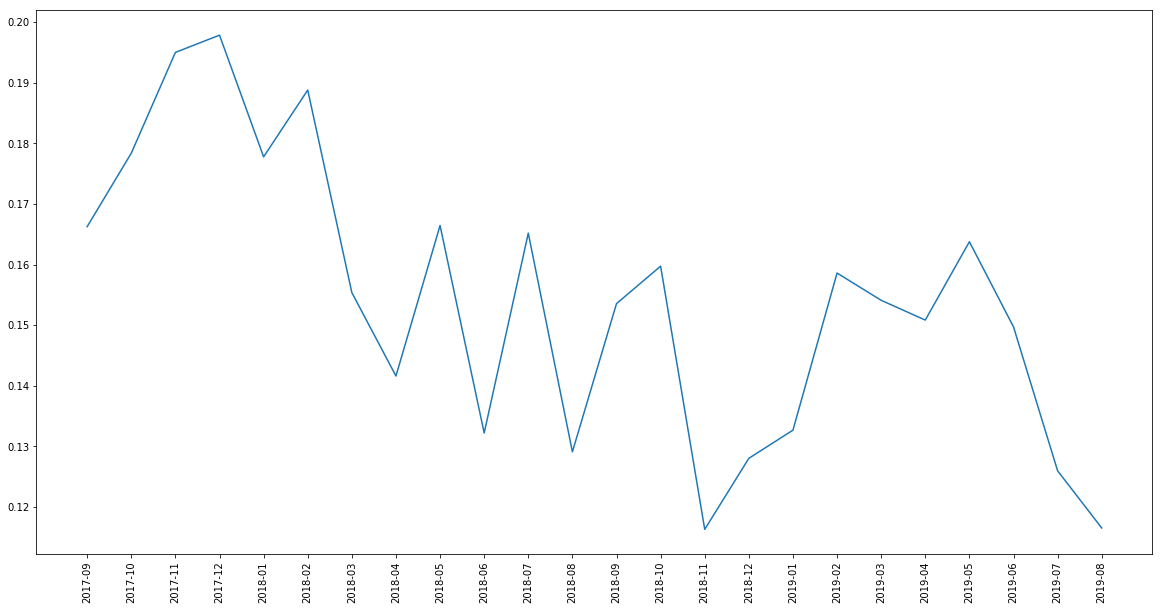

In [57]:
#plotting montly sentiment trends
x = df_monthly_sentiment.year_month
y = df_monthly_sentiment.sentiment

plt.figure(figsize = (20,10))

plt.xticks(rotation= 90)
plt.plot(x,y)

In [58]:
#plotting daily sentiment trends
#x = df_daily_sentiment.year_month_day
#y = df_daily_sentiment.compound_score

#plt.figure(figsize = (20,10))

#plt.xticks(rotation= 90)
#plt.plot(x,y)

#chart is really messy and nearly  unusable

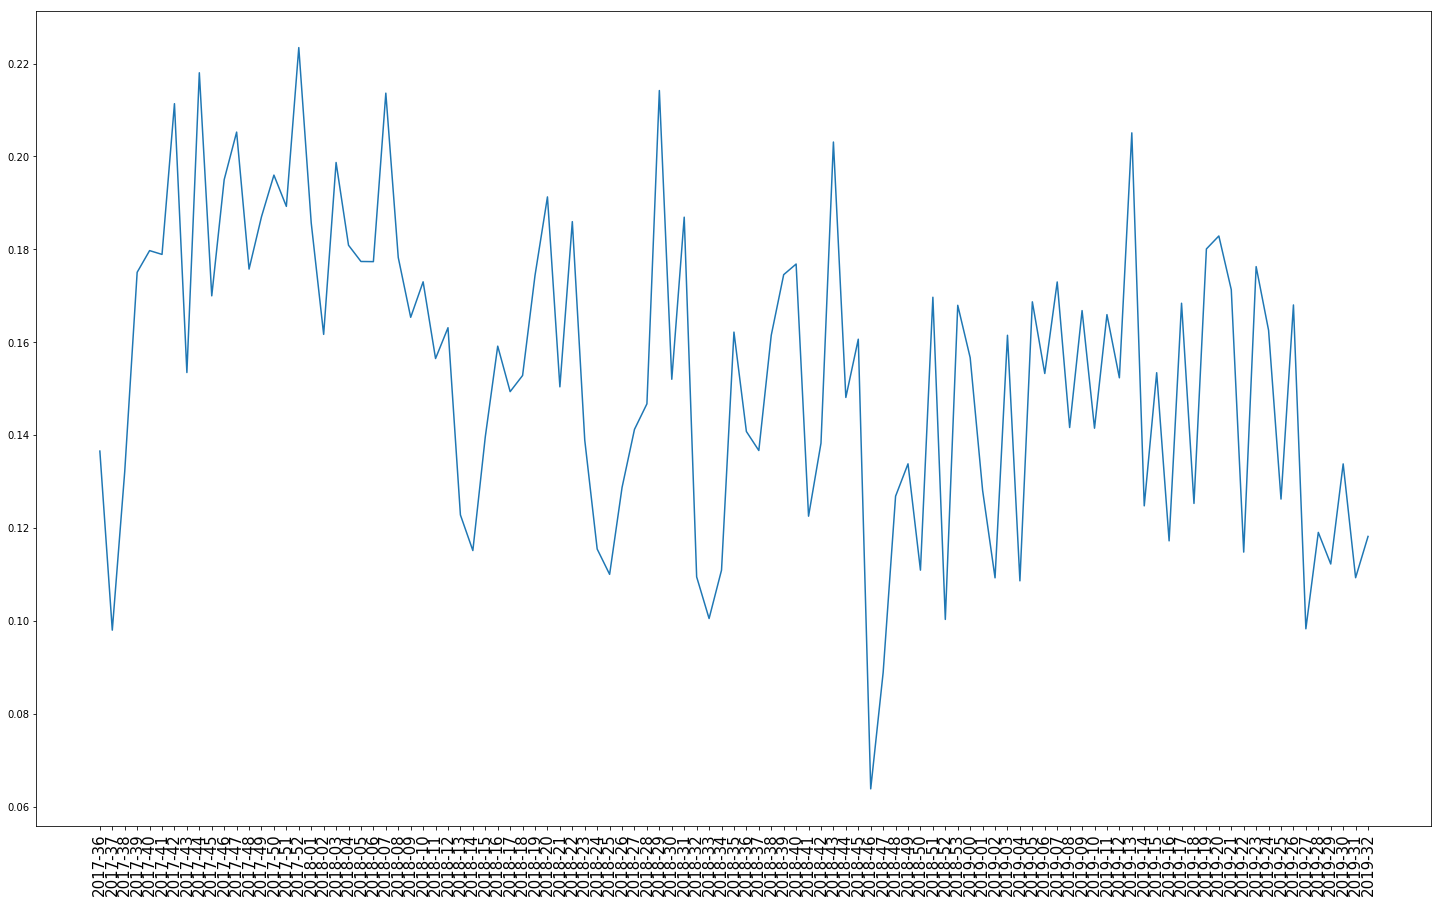

In [60]:
#plotting daily sentiment trends
x = df_weekly_sentiment.date_time_week
y = df_weekly_sentiment.sentiment

plt.figure(figsize = (25,15))

plt.xticks(fontsize = 15)

plt.xticks(rotation= 90)
plt.plot(x,y)

#chart is needs better labels possibly monthly labels and annotations will be good
#could potentially use tableau to do this

In [ ]:
#consider using mode or other kind of average?
#next section will use groupby and take the aggregate sentiment of days, weeks, months instead of the average

# 4. Sentiment Analysis -- Aggregated Corpus Sentiment

In [ ]:
#use concated corpus rather than averages to calcluate sentiment
#this is not working, might be something wrong with code or inefficient code ask lukas

In [ ]:
df_monthly_concat = df_analysis [['published_on','year_month','text']]

df_monthly_concat = df_monthly_concat[df_monthly_concat.published_on >= 1504224000]

#df_monthly_concat

In [ ]:
df_monthly_concat = df_monthly_concat.groupby(['year_month'])['text'].apply(' '.join).reset_index()

df_monthly_concat

In [ ]:
df_monthly_concat['compound_score'] = df_monthly_concat['text'].apply(lambda x: analyser.polarity_scores(x)['compound'])

In [ ]:
df_monthly_concat.to_pickle("./df_monthlyconcat.pkl")

In [ ]:
df_monthly_concat.head()